### Application Project Training Pipeline for Kaggle

- Trainings are done via Kaggle using Tesla T4 x2 GPUs
- You can find the related data in Kaggle via the link: https://www.kaggle.com/datasets/cetinkayaevren/gwdh-2021
- You can find the experiment results at comet.ml: https://www.comet.com/cetinkayaevren/wheat-head-detection/view/new/panels
- Note: These stored experiment results are for single model (not ensembled models). You can see the ensembled models results by running the notebook called "evaluate_ensemble_learning.ipynb"

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))
        
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
!pip install ultralytics comet_ml torch torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 1.7 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 874.8/874.8 kB 8.4 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 694.9/694.9 kB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 979.1/979.1 kB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 49.4 MB/s eta 0:00:00a 0:00:01
  Created wheel for configobj: filename=configobj-5.0.9-py2.py3-none-any.whl size=35614 sha256=2af4a997e7b18e35e3233b04999784490868a12b490800381dd85981861c1d3f
  Stored in directory: /root/.cache/pip/wheels/a1/6c/03/6c5e3cf1a6e4b9e2fc5c4409be4abc5a8268bd9c878739cb32
Successfully built configobj


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageDraw
import os
import shutil

# Model
import ultralytics
from ultralytics import YOLO
ultralytics.checks()

import torch

Ultralytics YOLOv8.2.102 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 5889.4/8062.4 GB disk)


In [3]:
#OPTIONAL: For recording training results to comet.ml

"""
import comet_ml
from comet_ml import Experiment, ExistingExperiment

#export COMET_API_KEY= pZv8flZqLNNV4mLfiakCpNCGM
experiment = comet_ml.init(project_name = "wheat-head-detection")


"""

COMET WARNING: comet_ml.init() is deprecated and will be removed soon. Please use comet_ml.login()


Please paste your Comet API key from https://www.comet.com/api/my/settings/
(api key may not show as you type)


Comet API key:  ·························


COMET INFO: Valid Comet API Key saved in /root/.comet.config (set COMET_CONFIG to change where it is saved).


'\nexperiment = Experiment(\n  api_key="pZv8flZqLNNV4mLfiakCpNCGM",\n  project_name="wheat-head-detection",\n  workspace="cetinkayaevren"\n)\n'

In [6]:
# Kaggle Data input, our data is available in Kaggle. You can find the data link at the top of this notebook

base_path = '/kaggle/input/gwdh-2021/gwhd_2021/'
os.listdir('/kaggle/input/gwdh-2021/gwhd_2021/')

['competition_train.csv',
 'metadata_dataset.csv',
 'val',
 'competition_test.csv',
 'competition_val.csv',
 'test',
 'train']

In [7]:
# Openiing Train Validation and Test Set

train_path = base_path + 'competition_train.csv'
validation_path = base_path + 'competition_val.csv'
test_path = base_path + 'competition_test.csv'

data_train = pd.read_csv(train_path)
data_val = pd.read_csv(validation_path)
data_test = pd.read_csv(test_path)

print(data_train.shape)

data_train.head()

(3657, 3)


image_name  \
0  4563856cc6d75c670eafd86d5eb7245fbe8f273c28f9e3...   
1  a2a15938845d9812de03bd44799c4b1bf856a8ad11752e...   
2  401f89a2bb6ab63e3f406bd59b9cadccfe953230feb6cd...   
3  0a3937653483c36dfb4d957b6f82ae96dbdc7ba36cc3d8...   
4  be1652110a44acd24b42784356e965ce84a04893c3f1bb...   

                                         BoxesString     domain  
0  99 692 160 764;641 27 697 115;935 978 1012 102...  Arvalis_1  
1  230 143 321 222;928 929 1015 1004;485 557 604 ...  Arvalis_1  
2  440 239 544 288;333 538 429 594;913 171 963 20...  Arvalis_1  
3  112 274 188 303;892 812 958 847;0 889 67 928;1...  Arvalis_1  
4  810 204 863 314;360 231 425 408;452 348 510 47...  Arvalis_1

In [8]:
# need to derive the indivivual boxes for Models
def string_to_array(group_string):
    group_strings = group_string.split(';')
    groups = []
    for group_str in group_strings:
        group = []
        for item in group_str.split():
            try:
                group.append(int(item))
            except ValueError:
                pass  # Skip non-integer values
        groups.append(group)
    return groups


# Apply the function to each element of the column and create a new column with the arrays
data_train['BoxesString'] = data_train['BoxesString'].apply(string_to_array)
data_val['BoxesString'] = data_val['BoxesString'].apply(string_to_array)
data_test['BoxesString'] = data_test['BoxesString'].apply(string_to_array)


In [9]:
# Print the DataFrame with the new column
data_train.head()

image_name  \
0  4563856cc6d75c670eafd86d5eb7245fbe8f273c28f9e3...   
1  a2a15938845d9812de03bd44799c4b1bf856a8ad11752e...   
2  401f89a2bb6ab63e3f406bd59b9cadccfe953230feb6cd...   
3  0a3937653483c36dfb4d957b6f82ae96dbdc7ba36cc3d8...   
4  be1652110a44acd24b42784356e965ce84a04893c3f1bb...   

                                         BoxesString     domain  
0  [[99, 692, 160, 764], [641, 27, 697, 115], [93...  Arvalis_1  
1  [[230, 143, 321, 222], [928, 929, 1015, 1004],...  Arvalis_1  
2  [[440, 239, 544, 288], [333, 538, 429, 594], [...  Arvalis_1  
3  [[112, 274, 188, 303], [892, 812, 958, 847], [...  Arvalis_1  
4  [[810, 204, 863, 314], [360, 231, 425, 408], [...  Arvalis_1

In [10]:
data_val.head()

image_name  \
0  e6b6a900e5c54cd5d8b0649768c361512cff1813409319...   
1  53889799be1319296f102fa09a512463c27316a428bb9f...   
2  ec8f9365ca93eb9dab075c64e5c8b32edd4f8993e17b89...   
3  48bab0505514c876207b4ede1c60cc906947ca02bb4277...   
4  44bf4657132a886bea1b74e105c3aadfa41ba7a2ae9d7a...   

                                         BoxesString   domain  
0  [[0, 30, 109, 119], [453, 617, 561, 661], [450...  Usask_1  
1  [[38, 370, 88, 443], [924, 824, 964, 874], [0,...  Usask_1  
2  [[884, 932, 1024, 990], [828, 53, 1024, 206], ...  Usask_1  
3  [[284, 114, 352, 181], [421, 0, 533, 90], [910...  Usask_1  
4  [[94, 0, 241, 183], [173, 217, 318, 338], [401...  Usask_1

In [11]:
data_test.head()

image_name  \
0  255b6ca9fea63f44125e5174bc932470b604c760430715...   
1  7f5eb37cab658de6fd0d688bf27f16e423794fed6184d8...   
2  7bcfff43b356f4a94948367782aa704a37ff4579baf45d...   
3  e535384eda9d0f9c6ac57dd9397d5d614e4cad48c144d8...   
4  66e9fa7379fd7b7fd64024ac1b03b8e56f9ad020c10635...   

                                         BoxesString domain  
0  [[481, 820, 604, 922], [655, 957, 732, 1024], ...   UQ_7  
1  [[896, 911, 977, 955], [800, 898, 821, 941], [...   UQ_7  
2  [[892, 993, 922, 1024], [844, 943, 871, 965], ...   UQ_7  
3  [[648, 886, 722, 1024], [392, 950, 507, 1024],...   UQ_7  
4  [[559, 939, 623, 1009], [775, 875, 829, 919], ...   UQ_7

In [12]:
# Explode the flattened array into individual rows
df_expanded_train = data_train.explode('BoxesString').reset_index(drop=True)
df_expanded_train.head()

image_name             BoxesString  \
0  4563856cc6d75c670eafd86d5eb7245fbe8f273c28f9e3...     [99, 692, 160, 764]   
1  4563856cc6d75c670eafd86d5eb7245fbe8f273c28f9e3...     [641, 27, 697, 115]   
2  4563856cc6d75c670eafd86d5eb7245fbe8f273c28f9e3...  [935, 978, 1012, 1020]   
3  4563856cc6d75c670eafd86d5eb7245fbe8f273c28f9e3...    [377, 834, 463, 890]   
4  4563856cc6d75c670eafd86d5eb7245fbe8f273c28f9e3...    [654, 797, 696, 837]   

      domain  
0  Arvalis_1  
1  Arvalis_1  
2  Arvalis_1  
3  Arvalis_1  
4  Arvalis_1

In [13]:
df_expanded_val = data_val.explode('BoxesString').reset_index(drop=True)
df_expanded_val.head()

image_name           BoxesString  \
0  e6b6a900e5c54cd5d8b0649768c361512cff1813409319...     [0, 30, 109, 119]   
1  e6b6a900e5c54cd5d8b0649768c361512cff1813409319...  [453, 617, 561, 661]   
2  e6b6a900e5c54cd5d8b0649768c361512cff1813409319...  [450, 441, 652, 493]   
3  e6b6a900e5c54cd5d8b0649768c361512cff1813409319...  [594, 617, 633, 657]   
4  e6b6a900e5c54cd5d8b0649768c361512cff1813409319...   [11, 719, 100, 840]   

    domain  
0  Usask_1  
1  Usask_1  
2  Usask_1  
3  Usask_1  
4  Usask_1

In [14]:
df_expanded_test = data_test.explode('BoxesString').reset_index(drop=True)
df_expanded_test.head()

image_name             BoxesString  \
0  255b6ca9fea63f44125e5174bc932470b604c760430715...    [481, 820, 604, 922]   
1  255b6ca9fea63f44125e5174bc932470b604c760430715...   [655, 957, 732, 1024]   
2  255b6ca9fea63f44125e5174bc932470b604c760430715...  [930, 926, 1013, 1024]   
3  255b6ca9fea63f44125e5174bc932470b604c760430715...    [809, 851, 910, 924]   
4  255b6ca9fea63f44125e5174bc932470b604c760430715...    [836, 904, 866, 967]   

  domain  
0   UQ_7  
1   UQ_7  
2   UQ_7  
3   UQ_7  
4   UQ_7

In [15]:
def extract_array_elements(row):
    return pd.Series(row['BoxesString'])

# Apply the function to create new columns
df_expanded_train[['x_min', 'y_min', 'x_max', 'y_max']] = df_expanded_train.apply(extract_array_elements, axis=1)
df_expanded_val[['x_min', 'y_min', 'x_max', 'y_max']] = df_expanded_val.apply(extract_array_elements, axis=1)
df_expanded_test[['x_min', 'y_min', 'x_max', 'y_max']] = df_expanded_test.apply(extract_array_elements, axis=1)

In [16]:
df_expanded_train.head()

image_name             BoxesString  \
0  4563856cc6d75c670eafd86d5eb7245fbe8f273c28f9e3...     [99, 692, 160, 764]   
1  4563856cc6d75c670eafd86d5eb7245fbe8f273c28f9e3...     [641, 27, 697, 115]   
2  4563856cc6d75c670eafd86d5eb7245fbe8f273c28f9e3...  [935, 978, 1012, 1020]   
3  4563856cc6d75c670eafd86d5eb7245fbe8f273c28f9e3...    [377, 834, 463, 890]   
4  4563856cc6d75c670eafd86d5eb7245fbe8f273c28f9e3...    [654, 797, 696, 837]   

      domain  x_min  y_min   x_max   y_max  
0  Arvalis_1   99.0  692.0   160.0   764.0  
1  Arvalis_1  641.0   27.0   697.0   115.0  
2  Arvalis_1  935.0  978.0  1012.0  1020.0  
3  Arvalis_1  377.0  834.0   463.0   890.0  
4  Arvalis_1  654.0  797.0   696.0   837.0

In [17]:
df_expanded_val.head()

image_name           BoxesString  \
0  e6b6a900e5c54cd5d8b0649768c361512cff1813409319...     [0, 30, 109, 119]   
1  e6b6a900e5c54cd5d8b0649768c361512cff1813409319...  [453, 617, 561, 661]   
2  e6b6a900e5c54cd5d8b0649768c361512cff1813409319...  [450, 441, 652, 493]   
3  e6b6a900e5c54cd5d8b0649768c361512cff1813409319...  [594, 617, 633, 657]   
4  e6b6a900e5c54cd5d8b0649768c361512cff1813409319...   [11, 719, 100, 840]   

    domain  x_min  y_min  x_max  y_max  
0  Usask_1    0.0   30.0  109.0  119.0  
1  Usask_1  453.0  617.0  561.0  661.0  
2  Usask_1  450.0  441.0  652.0  493.0  
3  Usask_1  594.0  617.0  633.0  657.0  
4  Usask_1   11.0  719.0  100.0  840.0

In [18]:
df_expanded_test.head()

image_name             BoxesString  \
0  255b6ca9fea63f44125e5174bc932470b604c760430715...    [481, 820, 604, 922]   
1  255b6ca9fea63f44125e5174bc932470b604c760430715...   [655, 957, 732, 1024]   
2  255b6ca9fea63f44125e5174bc932470b604c760430715...  [930, 926, 1013, 1024]   
3  255b6ca9fea63f44125e5174bc932470b604c760430715...    [809, 851, 910, 924]   
4  255b6ca9fea63f44125e5174bc932470b604c760430715...    [836, 904, 866, 967]   

  domain  x_min  y_min   x_max   y_max  
0   UQ_7  481.0  820.0   604.0   922.0  
1   UQ_7  655.0  957.0   732.0  1024.0  
2   UQ_7  930.0  926.0  1013.0  1024.0  
3   UQ_7  809.0  851.0   910.0   924.0  
4   UQ_7  836.0  904.0   866.0   967.0

In [19]:
counts = df_expanded_train['image_name'].value_counts()
print(f'number of boxes, range [{min(counts)}, {max(counts)}]')
sns.displot(counts, kde=False)
plt.xlabel('boxes')
plt.ylabel('images')
plt.title('Train data: boxes vs. images')
plt.show()

number of boxes, range [1, 129]


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


number of boxes, range [1, 129]


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


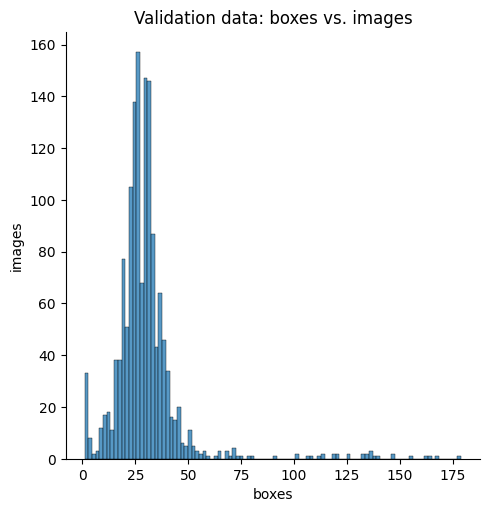

In [20]:
counts_val = df_expanded_val['image_name'].value_counts()
print(f'number of boxes, range [{min(counts)}, {max(counts)}]')
sns.displot(counts_val, kde=False)
plt.xlabel('boxes')
plt.ylabel('images')
plt.title('Validation data: boxes vs. images')
plt.show()

Number of Domains:  18


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


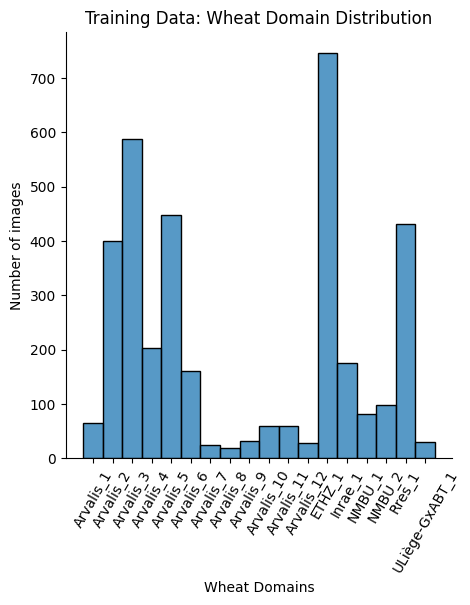

In [21]:
print("Number of Domains: ", len(data_train["domain"].unique()))
sns.displot(data_train["domain"], kde=False)
plt.xlabel('Wheat Domains')
plt.ylabel('Number of images')
plt.xticks(rotation=60)
plt.title('Training Data: Wheat Domain Distribution')
plt.show()

In [22]:
print("Number of Domains: ", len(data_val["domain"].unique()))
sns.displot(data_val["domain"], kde=False)
plt.xlabel('Wheat Domains')
plt.ylabel('Number of images')
plt.xticks(rotation=60)
plt.title('Validation Data: Wheat Domain Distribution')
plt.show()

Number of Domains:  11


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


In [23]:
domain_list = iter(data_train["domain"].unique())
fig, axs = plt.subplots(6, 3, figsize=(20, 30))

for rows in range(axs.shape[0]):
    for cols in range(axs.shape[1]):
        for region in domain_list:
            sample = data_train[data_train["domain"] == region].iloc[0]
            with Image.open(base_path+ "train/images" + "/" +sample["image_name"]) as im:
                draw = ImageDraw.Draw(im)
                for loc in sample["BoxesString"]:
                    xy = [(loc[0], loc[1]),(loc[2], loc[3])]
                    draw.rectangle(xy=xy, outline ="blue", width=5)
                axs[rows][cols].imshow(im)
                axs[rows][cols].axis("off")
                axs[rows][cols].title.set_text(region) 
            break
plt.suptitle('Training Data Domains and Ground Truths') # or plt.suptitle('Main title')
plt.show()

## Training Pipeline (YOLO V8)

# Warning: If you are using the data in Kaggle, you don't need to use the following cell that creates directories. Go to the next cell (creation of YAML files for training)

#### **WARNING**: This pipeline will change the data-folder structure and copy the images to different folders for having YOLO-formatted structure!! Be careful about you have enough storage.

#### Create Directories for train and validation

In [ ]:
os.makedirs(base_path + 'train/images', exist_ok = True)
os.makedirs(base_path + 'val/images', exist_ok = True)
os.makedirs(base_path + 'test/images', exist_ok = True)


os.makedirs(base_path + 'train/labels', exist_ok = True)
os.makedirs(base_path + 'val/labels', exist_ok = True)
os.makedirs(base_path + 'test/labels', exist_ok = True)


#### Create YAML File for YOLOv8 (Change your path in accordance with your project path!!!)

In [24]:
#IMPORTANT: CHANGE 'path' in accordance with your project path

content = '''
path: '/kaggle/working/'

train: '/kaggle/input/gwdh-2021/gwhd_2021/train/images'
val: '/kaggle/input/gwdh-2021/gwhd_2021/val/images'
    
names:
    0: wheat_head
'''

with open('GlobalWheatDataset.yaml', 'w') as file:
    file.write(content)

In [25]:
#IMPORTANT: CHANGE 'path' in accordance with your project path

content = '''
path: '/kaggle/working/'

train: '/kaggle/input/gwdh-2021/gwhd_2021/train/images'
val: '/kaggle/input/gwdh-2021/gwhd_2021/test/images'
    
names:
    0: wheat_head
'''

with open('GlobalWheatDataset_test.yaml', 'w') as file:
    file.write(content)

## Training

In [7]:
# Loading pre-trained YOLOv8l model
model = YOLO('yolov8l.pt')  #You can load the other YOLOv8 models (e.g. yolov8n.pt, yolov8s.pt, yolov8m.pt, yolov8x.pt)
model.info()

100%|██████████| 83.7M/83.7M [00:00<00:00, 248MB/s]


YOLOv8l summary: 365 layers, 43,691,520 parameters, 0 gradients, 165.7 GFLOPs


(365, 43691520, 0, 165.742848)

In [ ]:
# Training the model
results = model.train(
    data = '/kaggle/working/GlobalWheatDataset.yaml',
    epochs = 60,
    batch = 16,
    imgsz = 1024,
    optimizer = 'AdamW',
    device=[0, 1],
    project="wheat-head-detection"
)

Ultralytics YOLOv8.2.87 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)
                                                      CUDA:1 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8l.pt, data=/kaggle/working/GlobalWheatDataset.yaml, epochs=60, time=None, patience=100, batch=16, imgsz=1024, save=True, save_period=-1, cache=False, device=[0, 1], workers=8, project=wheat-head-detection, name=train, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False,

100%|██████████| 755k/755k [00:00<00:00, 19.8MB/s]
2024-09-04 09:32:56,175	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-09-04 09:32:57,029	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  3    279808  ultralytics.nn.modules.block.C2f             [128, 128, 3, True]           
  3                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  4                  -1  6   2101248  ultralytics.nn.modules.block.C2f             [256, 256, 6, True]           
  5                  -1  1   1180672  ultralytics.nn.modules.conv.Conv             [256, 512, 3, 2]              
  6                  -1  6   8396800  ultralytics.nn.modules.block.C2f             [512, 512, 6, True]           
  7                  -1  1   2360320  ultralytics

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
COMET WARNING: Failing to collect the installed pip packages
COMET INFO: Experiment is live on comet.com https://www.comet.com/cetinkayaevren/wheat-head-detection/744461ff8e1d4fcf851ba2d2f4ae6232

COMET INFO: Couldn't find a Git repository in '/kaggle/working' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.


TensorBoard: Start with 'tensorboard --logdir wheat-head-detection/train', view at http://localhost:6006/
Overriding model.yaml nc=80 with nc=1
Transferred 589/595 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...


100%|██████████| 6.25M/6.25M [00:00<00:00, 89.9MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/input/gwdh-2021/gwhd_2021/train/labels... 3605 images, 50 backgrounds, 0 corrupt: 100%|██████████| 3655/3655 [00:37<00:00, 96.25it/s] 


train: WARNING ⚠️ /kaggle/input/gwdh-2021/gwhd_2021/train/images/502d5e4a8b89aeffaa6adf13e1215d27c2951230ab06a4fcb93732117196f124.png: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/input/gwdh-2021/gwhd_2021/train/images/8b461a21b9b01c657d41dfdf35b3607a0ab920c2cb78184c6e523391f5f3d554.png: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/input/gwdh-2021/gwhd_2021/train/images/9f697765bd41325baaf635d5389020270c4536200f97884928c014ac1d39ce12.png: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/input/gwdh-2021/gwhd_2021/train/images/c1db9589b954aa1ef2b5bf065d09aba926e674679a553c6dd6bfd5d6ae81f86a.png: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/input/gwdh-2021/gwhd_2021/train/images/ed17cba877ba4983b072ead24480913fb4cff9f1fc0f920e07021ca4f4f2ace2.png: 1 duplicate labels removed
train: WARNING ⚠️ Cache directory /kaggle/input/gwdh-2021/gwhd_2021/train is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/input/gwdh-2021/gwhd_2021/val/labels... 1448 images, 28 backgrounds, 0 corrupt: 100%|██████████| 1476/1476 [00:15<00:00, 95.61it/s]it/s]
train: Scanning /kaggle/input/gwdh-2021/gwhd_2021/train/labels... 2899 images, 42 backgrounds, 0 corrupt:  80%|████████  | 2941/3655 [00:20<00:04, 155.02it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/gwdh-2021/gwhd_2021/val is not writeable, cache not saved.


train: Scanning /kaggle/input/gwdh-2021/gwhd_2021/train/labels... 2919 images, 42 backgrounds, 0 corrupt:  81%|████████  | 2961/3655 [00:20<00:04, 165.83it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
train: Scanning /kaggle/input/gwdh-2021/gwhd_2021/train/labels... 3010 images, 42 backgrounds, 0 corrupt:  84%|████████▎ | 3052/3655 [00:21<00:03, 169.85it/s]

Plotting labels to wheat-head-detection/train/labels.jpg... 


train: Scanning /kaggle/input/gwdh-2021/gwhd_2021/train/labels... 3605 images, 50 backgrounds, 0 corrupt: 100%|██████████| 3655/3655 [00:25<00:00, 142.32it/s]


optimizer: AdamW(lr=0.01, momentum=0.937) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 4 dataloader workers
Logging results to wheat-head-detection/train
Starting training for 60 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/60      14.9G      1.766      1.187      1.655        235       1024: 100%|██████████| 229/229 [04:10<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 93/93 [01:31<00:00,  1.02it/s]


                   all       1476      44347      0.198       0.28      0.141     0.0521

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/60      14.9G      1.712      1.013      1.625        318       1024: 100%|██████████| 229/229 [03:59<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 93/93 [01:23<00:00,  1.11it/s]


                   all       1476      44347      0.624      0.505      0.556      0.254

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/60      14.3G      1.657     0.9363      1.617        188       1024: 100%|██████████| 229/229 [03:58<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 93/93 [01:15<00:00,  1.23it/s]


                   all       1476      44347      0.792       0.72      0.795      0.404

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/60      14.3G      1.625     0.8983      1.584        291       1024: 100%|██████████| 229/229 [03:58<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 93/93 [01:15<00:00,  1.24it/s]


                   all       1476      44347       0.82      0.681       0.77      0.382

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/60      14.4G       1.58     0.8448      1.565        201       1024: 100%|██████████| 229/229 [03:58<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 93/93 [01:15<00:00,  1.23it/s]


                   all       1476      44347      0.858      0.788      0.868      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/60      13.8G      1.586     0.8324      1.571        261       1024: 100%|██████████| 229/229 [03:56<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 93/93 [01:14<00:00,  1.25it/s]


                   all       1476      44347      0.874      0.781       0.87      0.469

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/60        14G      1.592      0.848      1.583        154       1024: 100%|██████████| 229/229 [03:58<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 93/93 [01:14<00:00,  1.25it/s]


                   all       1476      44347      0.881      0.785      0.875      0.472

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/60      14.9G      1.556     0.7992      1.554        289       1024: 100%|██████████| 229/229 [03:57<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 93/93 [01:14<00:00,  1.24it/s]


                   all       1476      44347      0.882      0.733      0.838      0.463

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/60      14.8G      1.558     0.8006      1.561        253       1024: 100%|██████████| 229/229 [03:57<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 93/93 [01:15<00:00,  1.24it/s]


                   all       1476      44347      0.861      0.779      0.864      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/60      14.7G       1.53     0.7806      1.531        301       1024: 100%|██████████| 229/229 [03:58<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 93/93 [01:15<00:00,  1.24it/s]


                   all       1476      44347      0.836      0.766      0.842      0.412

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/60      13.3G      1.552     0.7842      1.549        300       1024: 100%|██████████| 229/229 [03:57<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 93/93 [01:14<00:00,  1.24it/s]


                   all       1476      44347      0.905      0.802      0.894      0.507

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/60      15.3G      1.515     0.7646      1.528        321       1024: 100%|██████████| 229/229 [03:58<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 93/93 [01:14<00:00,  1.25it/s]


                   all       1476      44347      0.902      0.807      0.886      0.478

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/60      14.5G      1.542     0.7754      1.535        202       1024: 100%|██████████| 229/229 [03:58<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 93/93 [01:14<00:00,  1.24it/s]


                   all       1476      44347      0.884      0.801      0.882      0.469

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/60      15.4G      1.508     0.7583      1.523        186       1024: 100%|██████████| 229/229 [03:57<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 93/93 [01:14<00:00,  1.25it/s]


                   all       1476      44347       0.91      0.808      0.895      0.492

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/60      15.1G      1.509     0.7572      1.516        394       1024: 100%|██████████| 229/229 [03:57<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 93/93 [01:14<00:00,  1.24it/s]


                   all       1476      44347      0.883      0.762      0.852      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/60      13.9G      1.496     0.7312      1.503        236       1024: 100%|██████████| 229/229 [03:57<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 93/93 [01:15<00:00,  1.24it/s]


                   all       1476      44347      0.892      0.794      0.886      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/60      14.2G      1.496     0.7345      1.524        398       1024: 100%|██████████| 229/229 [03:57<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 93/93 [01:14<00:00,  1.24it/s]


                   all       1476      44347      0.902      0.835      0.907       0.48

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/60      14.7G       1.48      0.717      1.497        218       1024: 100%|██████████| 229/229 [03:57<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 93/93 [01:15<00:00,  1.23it/s]


                   all       1476      44347      0.889      0.833      0.898      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/60      13.9G      1.476     0.7206      1.512        313       1024: 100%|██████████| 229/229 [03:57<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 93/93 [01:15<00:00,  1.24it/s]


                   all       1476      44347      0.864      0.769      0.859      0.414

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/60      15.2G      1.481     0.7199      1.503        294       1024: 100%|██████████| 229/229 [03:56<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 93/93 [01:15<00:00,  1.24it/s]


                   all       1476      44347      0.904      0.836      0.907      0.479

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/60      15.2G      1.482     0.7161        1.5        367       1024: 100%|██████████| 229/229 [03:57<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 93/93 [01:15<00:00,  1.23it/s]


                   all       1476      44347      0.876      0.792      0.876      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/60      14.9G      1.458     0.7089      1.486        246       1024: 100%|██████████| 229/229 [03:57<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 93/93 [01:14<00:00,  1.25it/s]


                   all       1476      44347      0.902       0.79      0.879      0.499

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/60      13.4G      1.461      0.714      1.484        378       1024: 100%|██████████| 229/229 [03:56<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 93/93 [01:15<00:00,  1.24it/s]


                   all       1476      44347      0.895       0.84      0.905      0.455

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/60      15.2G      1.465     0.7086      1.482        194       1024: 100%|██████████| 229/229 [03:57<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 93/93 [01:14<00:00,  1.24it/s]


                   all       1476      44347       0.91      0.824        0.9      0.468

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/60      13.9G      1.477     0.7101      1.504        184       1024: 100%|██████████| 229/229 [03:56<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 93/93 [01:15<00:00,  1.24it/s]


                   all       1476      44347      0.895      0.829      0.902      0.456

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/60      13.5G      1.452     0.6963      1.481        297       1024: 100%|██████████| 229/229 [03:56<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 93/93 [01:14<00:00,  1.24it/s]


                   all       1476      44347      0.901      0.833      0.907      0.479

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/60      14.5G      1.439     0.6938      1.473        263       1024: 100%|██████████| 229/229 [03:57<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 93/93 [01:14<00:00,  1.25it/s]


                   all       1476      44347      0.899       0.83      0.904      0.464

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/60        14G      1.434     0.6803      1.472        318       1024: 100%|██████████| 229/229 [03:57<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 93/93 [01:14<00:00,  1.24it/s]


                   all       1476      44347      0.906      0.848      0.916      0.478

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/60        15G      1.451     0.6913      1.496        120       1024: 100%|██████████| 229/229 [03:57<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 93/93 [01:14<00:00,  1.24it/s]


                   all       1476      44347      0.906      0.836      0.909      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/60      14.1G      1.445      0.681      1.479        232       1024: 100%|██████████| 229/229 [03:57<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 93/93 [01:14<00:00,  1.25it/s]


                   all       1476      44347       0.91      0.851      0.918      0.482

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/60      15.2G      1.428     0.6757      1.477        201       1024: 100%|██████████| 229/229 [03:57<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 93/93 [01:14<00:00,  1.24it/s]


                   all       1476      44347      0.917      0.833       0.91       0.49

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/60        15G      1.428     0.6756      1.469        179       1024: 100%|██████████| 229/229 [03:57<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 93/93 [01:15<00:00,  1.24it/s]


                   all       1476      44347      0.902       0.85      0.912      0.471

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/60      14.9G      1.413     0.6621       1.45        325       1024: 100%|██████████| 229/229 [03:57<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 93/93 [01:14<00:00,  1.24it/s]


                   all       1476      44347      0.894      0.843      0.906      0.462

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/60      14.3G      1.419     0.6614      1.456        494       1024:  44%|████▎     | 100/229 [01:44<02:15,  1.05s/it]

### Testing the best model with test dataset

In [14]:
# Test,ng Model
model_test = YOLO("/kaggle/working/wheat-head-detection/train/weights/best.pt")  # load the best model

metrics = model.val(data="/kaggle/working/GlobalWheatDataset_test.yaml")

Ultralytics YOLOv8.2.87 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)
                                                      CUDA:1 (Tesla T4, 15095MiB)
Model summary (fused): 218 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs


val: Scanning /kaggle/input/gwdh-2021/gwhd_2021/test/labels... 1334 images, 47 backgrounds, 3 corrupt: 100%|██████████| 1381/1381 [00:08<00:00, 156.93it/s]

val: WARNING ⚠️ /kaggle/input/gwdh-2021/gwhd_2021/test/images/0af5c1bc753619e4f5d504e5424d056af22954f04d50cd0d4a21682cfdd9a4dc.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0195      1.0059      1.0088      1.0176      1.0229      1.0161      1.0059]
val: WARNING ⚠️ /kaggle/input/gwdh-2021/gwhd_2021/test/images/4c9c82eeefaaa8b3b7300561820274c0ff576b47ada9239862f4a295cbdb18b7.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0356      1.0083]
val: WARNING ⚠️ /kaggle/input/gwdh-2021/gwhd_2021/test/images/6be51c1a5132034427ecabaafa679fcac7c8f95e05a595df69401766b90d7890.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.001      1.0225      1.0244]
val: WARNING ⚠️ /kaggle/input/gwdh-2021/gwhd_2021/test/images/b5693f35d46830f4f1b35e09f7933f76f234cc641cc8b58dfec7da533231b4ad.png: 1 duplicate labels removed


val: WARNING ⚠️ Cache directory /kaggle/input/gwdh-2021/gwhd_2021/test is not writeable, cache not saved.


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   2%|▏         | 2/87 [00:04<03:50,  2.72s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 87/87 [01:54<00:00,  1.32s/it]


                   all       1378      67309      0.805      0.623      0.709      0.305
Speed: 0.6ms preprocess, 56.6ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to wheat-head-detection/train2


In [15]:
print(metrics.box.map)  # map50-95
print(metrics.box.map50)  # map50
print(metrics.box.map75)  # map75
print(metrics.box.maps)  # a list contains map50-95 of each category

0.30502129613285317
0.7086818471612342
0.2019528213678919
[    0.30502]


### Results are saved to another Folder (runs/detect/train{current_number})

In [16]:
# OPTIONAL: Storing the experiment results to the comet.ml

"""
from comet_ml import ExistingExperiment
test_metrics = {
   "metrics/test/mAP50(B)": metrics.box.map50,
   "metrics/test/mAP50-95(B)": metrics.box.map,
   "metrics/test/mAP75": metrics.box.map75,
}

exp = ExistingExperiment(api_key="pZv8flZqLNNV4mLfiakCpNCGM", previous_experiment="<experiment_id>"")
exp.log_metrics(test_metrics)
exp.end()
"""

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/cetinkayaevren/wheat-head-detection/80e4da305e36418db12c0be058cae73d

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : apparent_cornice_5642
COMET INFO:     url                   : https://www.comet.com/cetinkayaevren/wheat-head-detection/80e4da305e36418db12c0be058cae73d
COMET INFO:   Metrics:
COMET INFO:     metrics/test/mAP50(B)    : 0.7086818471612342
COMET INFO:     metrics/test/mAP50-95(B) : 0.30502129613285317
COMET INFO:     metrics/test/mAP75      